# Part 1
# Doc2Vec (PV-DBOW) from Scratch

This notebook implements PV-DBOW (Distributed Bag of Words) Doc2Vec from scratch using PyTorch.
It follows the assignment steps: preprocessing, tokenization, vocabulary creation, negative sampling, training, plotting loss, and similarity retrieval.


In [ ]:
import os
import random
from collections import Counter
from typing import List, Tuple


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

## Setup and Data Loading

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)



DATA_PATH = 'kickstarter_data_full.csv' 


if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please download and save the CSV with a 'blurb' column.")


df = pd.read_csv(DATA_PATH)
print('Loaded rows:', len(df))

Using device: cuda
Loaded rows: 20632


/tmp/ipython-input-3797259672.py:24: DtypeWarning: Columns (30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


## Display first 5 rows of the dataframe

In [ ]:
df.head(5)

,index,Unnamed: 0,id,photo,name,blurb,goal,pledged,state,slug,...,launch_to_deadline,launch_to_state_change,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,SuccessfulBool,USorGB,TOPCOUNTRY,LaunchedTuesday,DeadlineWeekend
0,0,0,1454391034,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,0.0,failed,auntie-dis-music-time-sign-asl-for-hearing-and...,...,36 days 20:47:24.000000000,36 days 20:47:24.000000000,17,36,36,0,1,1,0,0
1,1,1,1655206086,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,0.0,failed,jump-start-kindergarten-toolkit,...,60 days 00:00:00.000000000,60 days 00:00:02.000000000,10,60,60,0,1,1,0,0
2,2,2,311581827,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,120.0,failed,ojukwu-balewa-awolowo-oba-public-library-of-ni...,...,60 days 00:00:00.000000000,60 days 00:00:01.000000000,1,60,60,0,1,1,0,0
3,3,3,859724515,"{""small"":""https://ksr-ugc.imgix.net/assets/011...","MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,0.0,failed,mastize-mas-tahyz-mas-tahyz-to-spread,...,30 days 00:00:00.000000000,30 days 00:00:00.000000000,0,30,30,0,1,1,0,0
4,4,4,1613604977,"{""small"":""https://ksr-ugc.imgix.net/assets/012...","Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,356.0,failed,synopse-der-eu-dsgvo-artikel-erwagungsgrunde-bdsg,...,32 days 06:02:33.000000000,32 days 06:02:33.000000000,0,32,32,0,0,0,0,0


## Display shape of the dataframe

In [ ]:
df.shape

(20632, 69)

## Display the 'blurb' column

In [ ]:
df['blurb']

,blurb
0,MTS ASL Curriculum Workbook is a reproducible ...
1,"This kit teaches how to print, correct an ugly..."
2,"Establishing a free, world-class, public libra..."
3,Goal: Introducing a new word into the English ...
4,Zu den Artikeln der DSGVO sind die korrespondi...
...,...
20627,The easy way to be present for story time anyt...
20628,A revolutionary App that makes getting fit as ...
20629,"We all love fatbooth and Ugly booth, why not s..."
20630,Production android app for cab drivers and tru...


## Display the first few blurbs

In [ ]:
# Show a few blurbs
print(df['blurb'].astype(str).head().to_list())

['MTS ASL Curriculum Workbook is a reproducible study book to build Early Literacy and Academic skills for primary school age children.', "This kit teaches how to print, correct an ugly grasp, and how to make sure your child's fine motor skills are kindergarten ready!", 'Establishing a free, world-class, public library which will be a center  for curating and disseminating knowledge in Nigeria.', 'Goal: Introducing a new word into the English language/dictionary.\nReason: The beauty of the English language is the freedom to create.', 'Zu den Artikeln der DSGVO sind die korrespondierenden Erwägungsgründe und die vergleichbaren Regelungen aus dem BDSG gegenüber gestellt']


## Keep only rows with non-empty blurbs

In [ ]:
# Keep only rows with non-empty blurbs
df = df[df['blurb'].notnull()].reset_index(drop=True)

## 3) Preprocessing and Tokenization

We'll perform simple preprocessing steps: lowercasing text, removing punctuation, and splitting on whitespace.  
This serves as a basic **word-level tokenizer**, as requested.



In [ ]:
import re


WORD_MIN_FREQ = 5 # minimum frequency to keep a word in the vocab
MAX_VOCAB_SIZE = 30000 # cap vocab size


def preprocess(text: str) -> str:
    text = str(text).lower()
    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # replace non-alphanumeric characters with spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply preprocessing
raw_texts = df['blurb'].astype(str).apply(preprocess).tolist()


# Tokenize by whitespace
tokenized_texts = [t.split() for t in raw_texts]
print('Example tokens:', tokenized_texts[0][:20])

Example tokens: ['mts', 'asl', 'curriculum', 'workbook', 'is', 'a', 'reproducible', 'study', 'book', 'to', 'build', 'early', 'literacy', 'and', 'academic', 'skills', 'for', 'primary', 'school', 'age']


## Create vocabulary

In [ ]:
# Count tokens
counter = Counter(token for doc in tokenized_texts for token in doc)
print('Total unique tokens before filtering:', len(counter))


# Keep tokens above frequency threshold
vocab_tokens = [tok for tok, freq in counter.items() if freq >= WORD_MIN_FREQ]
# Sort by frequency
vocab_tokens.sort(key=lambda t: -counter[t])
# Cap size
vocab_tokens = vocab_tokens[:MAX_VOCAB_SIZE]


# Add special token for unknown
UNK_TOKEN = '<UNK>'
itos = [UNK_TOKEN] + vocab_tokens
stoi = {tok: i for i, tok in enumerate(itos)}


VOCAB_SIZE = len(itos)
print('Final vocab size:', VOCAB_SIZE)

Total unique tokens before filtering: 29568
Final vocab size: 6561


## Convert documents to word ids

In [ ]:
# Convert docs to word ids (filtered)
docs_word_ids = [[stoi.get(tok, 0) for tok in doc if tok in stoi] for doc in tokenized_texts]
# Filter out documents that became empty after filtering
valid_doc_indices = [i for i, doc in enumerate(docs_word_ids) if len(doc) > 0]
print('Docs with at least one in-vocab word:', len(valid_doc_indices), '/', len(docs_word_ids))


# Keep only valid docs
docs_word_ids = [docs_word_ids[i] for i in valid_doc_indices]
raw_texts = [raw_texts[i] for i in valid_doc_indices]
df = df.iloc[valid_doc_indices].reset_index(drop=True)
NUM_DOCS = len(docs_word_ids)
print('Training on', NUM_DOCS, 'documents')

Docs with at least one in-vocab word: 20600 / 20626
Training on 20600 documents


## 5) Negative sampling distribution
Use unigram distribution raised to 3/4 as in word2vec
Precompute frequencies for vocabulary (use counts but set UNK count)

In [ ]:
word_counts = np.zeros(VOCAB_SIZE, dtype=np.float64)
for doc in docs_word_ids:
    for wid in doc:
        word_counts[wid] += 1.0
# ensure UNK has some count
if word_counts[0] == 0:
    word_counts[0] = 1.0


unigram = word_counts / word_counts.sum()
unigram_34 = unigram ** 0.75
unigram_34 /= unigram_34.sum()

## Define DocWordDataset

In [ ]:
class DocWordDataset(Dataset):
    def __init__(self, docs: List[List[int]], samples_per_doc: int = 5):
        self.docs = docs
        self.samples_per_doc = samples_per_doc
        # We'll create a list of (doc_id, word_id) pairs by sampling
        pairs = []
        for doc_id, doc in enumerate(docs):
            for _ in range(self.samples_per_doc):
                w = random.choice(doc)
                pairs.append((doc_id, w))
        self.pairs = pairs


    def __len__(self):
        return len(self.pairs)


    def __getitem__(self, idx):
        return self.pairs[idx]

## Create dataset and dataloader

In [ ]:
# Create dataset
SAMPLES_PER_DOC = 10
dataset = DocWordDataset(docs_word_ids, samples_per_doc=SAMPLES_PER_DOC)
print('Total training pairs:', len(dataset))


BATCH_SIZE = 512
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Total training pairs: 206000


## Model: PV-DBOW with negative sampling
Document embeddings matrix (NUM_DOCS x DIM)
Output word embeddings (VOCAB_SIZE x DIM) used to score dot(doc_vec, word_vec)
We'll use logistic loss with negative sampling.

In [ ]:
EMBED_DIM = 128
NEGATIVE_SAMPLES = 5


class PVDBOW(nn.Module):
    def __init__(self, num_docs, vocab_size, dim):
        super().__init__()
        self.doc_emb = nn.Embedding(num_docs, dim)
        self.out_emb = nn.Embedding(vocab_size, dim)
        # initialize
        nn.init.xavier_uniform_(self.doc_emb.weight)
        nn.init.xavier_uniform_(self.out_emb.weight)


    def forward_positive(self, doc_ids, pos_word_ids):
        # doc_ids: (B,), pos_word_ids: (B,)
        d = self.doc_emb(doc_ids) # (B, dim)
        w = self.out_emb(pos_word_ids) # (B, dim)
        scores = (d * w).sum(dim=1) # (B,)
        return scores


    def forward_negative(self, doc_ids, neg_word_ids):
        # neg_word_ids: (B, K)
        d = self.doc_emb(doc_ids).unsqueeze(1) # (B,1,dim)
        w = self.out_emb(neg_word_ids) # (B,K,dim)
        scores = (d * w).sum(dim=2) # (B,K)
        return scores


model = PVDBOW(NUM_DOCS, VOCAB_SIZE, EMBED_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Model Training with negative sampling
Use binary cross entropy on positive and negative samples (logistic loss). We use logits and BCEWithLogitsLoss.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()


EPOCHS = 20
print_every = 50


all_losses = []
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        doc_ids, pos_word_ids = batch
        doc_ids = doc_ids.to(DEVICE)
        pos_word_ids = pos_word_ids.to(DEVICE)


        # Sample negatives for each positive
        neg_word_ids = np.random.choice(np.arange(VOCAB_SIZE), size=(doc_ids.size(0), NEGATIVE_SAMPLES), p=unigram_34)
        neg_word_ids = torch.LongTensor(neg_word_ids).to(DEVICE)


        optimizer.zero_grad()


        pos_scores = model.forward_positive(doc_ids, pos_word_ids) # (B,)
        neg_scores = model.forward_negative(doc_ids, neg_word_ids) # (B,K)


        # Positive labels = 1, negative labels = 0
        pos_labels = torch.ones_like(pos_scores)
        neg_labels = torch.zeros_like(neg_scores)


        loss_pos = loss_fn(pos_scores, pos_labels)
        loss_neg = loss_fn(neg_scores, neg_labels)
        loss = loss_pos + loss_neg.mean()


        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        if (i + 1) % print_every == 0:
            avg = running_loss / print_every
            print(f'Epoch {epoch} iter {i+1}/{len(dataloader)} avg_loss={avg:.4f}')
            all_losses.append(avg)
            running_loss = 0.0


    # At epoch end, append epoch average if not captured
    if running_loss > 0:
        all_losses.append(running_loss / max(1, len(dataloader)))

Epoch 1 iter 50/402 avg_loss=0.3189
Epoch 1 iter 100/402 avg_loss=0.3174
Epoch 1 iter 150/402 avg_loss=0.3151
Epoch 1 iter 200/402 avg_loss=0.3122
Epoch 1 iter 250/402 avg_loss=0.3086
Epoch 1 iter 300/402 avg_loss=0.3109
Epoch 1 iter 350/402 avg_loss=0.3067
Epoch 1 iter 400/402 avg_loss=0.3091
Epoch 2 iter 50/402 avg_loss=0.2747
Epoch 2 iter 100/402 avg_loss=0.2754
Epoch 2 iter 150/402 avg_loss=0.2737
Epoch 2 iter 200/402 avg_loss=0.2733
Epoch 2 iter 250/402 avg_loss=0.2726
Epoch 2 iter 300/402 avg_loss=0.2719
Epoch 2 iter 350/402 avg_loss=0.2703
Epoch 2 iter 400/402 avg_loss=0.2712
Epoch 3 iter 50/402 avg_loss=0.2411
Epoch 3 iter 100/402 avg_loss=0.2379
Epoch 3 iter 150/402 avg_loss=0.2419
Epoch 3 iter 200/402 avg_loss=0.2421
Epoch 3 iter 250/402 avg_loss=0.2401
Epoch 3 iter 300/402 avg_loss=0.2411
Epoch 3 iter 350/402 avg_loss=0.2407
Epoch 3 iter 400/402 avg_loss=0.2411
Epoch 4 iter 50/402 avg_loss=0.2138
Epoch 4 iter 100/402 avg_loss=0.2144
Epoch 4 iter 150/402 avg_loss=0.2135
Epoch

# Save model

In [ ]:
# Save model
torch.save(model.state_dict(), 'pvdbow_model.pth')
print('Training complete. Model saved to pvdbow_model.pth')

Training complete. Model saved to pvdbow_model.pth


## Plot training loss

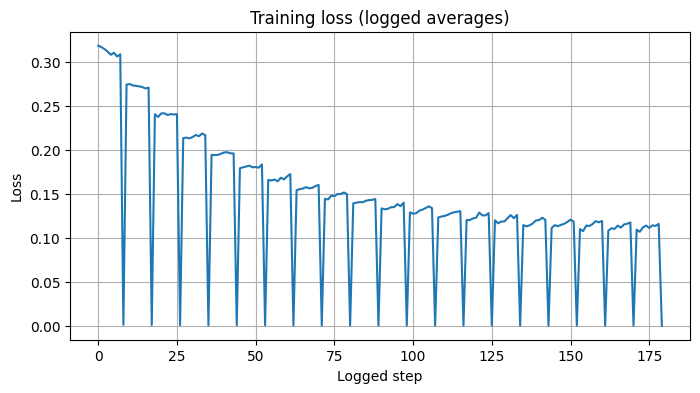

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(all_losses)
plt.xlabel('Logged step')
plt.ylabel('Loss')
plt.title('Training loss (logged averages)')
plt.grid(True)

plt.savefig("training_loss_logged_averages.png", dpi=300, bbox_inches='tight')
plt.show()

## Extract document embeddings and compute similarities
We'll compute cosine similarity between document vectors.

In [ ]:
model.eval()
with torch.no_grad():
    doc_embeddings = model.doc_emb.weight.cpu().numpy() # (NUM_DOCS, dim)
# Normalize
norms = np.linalg.norm(doc_embeddings, axis=1, keepdims=True)
norms[norms==0] = 1e-9
doc_normed = doc_embeddings / norms

# Cosine similarity between all docs (you might not want to compute full matrix if NUM_DOCS is huge)
# We'll compute similarities for a chosen example doc.

# Choose an example doc (e.g., index 0)
EXAMPLE_DOC_INDEX = 0
example_vec = doc_normed[EXAMPLE_DOC_INDEX:EXAMPLE_DOC_INDEX+1]

sims = (doc_normed @ example_vec.T).squeeze() # cosine similarities

# Sort and get top 5 (excluding the doc itself)
order = sims.argsort()[::-1]
# remove self
order = [idx for idx in order if idx != EXAMPLE_DOC_INDEX]

top5 = order[:5]
bottom5 = order[-5:]

print('Example blurb:')
print(raw_texts[EXAMPLE_DOC_INDEX])
print('\nTop 5 similar documents:')
for idx in top5:
    print(f'Idx {idx} sim={sims[idx]:.4f} ->', raw_texts[idx][:200])

print('\nTop 5 dissimilar documents (lowest cosine):')
for idx in bottom5:
    print(f'Idx {idx} sim={sims[idx]:.4f} ->', raw_texts[idx][:200])

Example blurb:
mts asl curriculum workbook is a reproducible study book to build early literacy and academic skills for primary school age children

Top 5 similar documents:
Idx 9343 sim=0.5496 -> this is a e book about comparative listing of how to in commonly used programming language viz java perl c bash
Idx 7116 sim=0.5343 -> revolutionary new source of useful information about children s education and their development from early stages
Idx 4903 sim=0.5286 -> technology curriculum for underserved underprivileged schools and their students
Idx 11248 sim=0.5269 -> linkup is a social networking app for business professionals
Idx 1381 sim=0.5264 -> creating a consuite for corecon a focus on the insanity of asylums and early medical practices from history

Top 5 dissimilar documents (lowest cosine):
Idx 13145 sim=-0.0634 -> want people to put down their phone more often ransomly creates quiet spaces to help us reconnect with the real people in our lives
Idx 1215 sim=-0.0657 -> surrey y

## Part 2
Neural Network Text Classification using Qwen3 pretrained embeddings

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Load embeddings and categories

In [ ]:
# ------------------ Load Data ------------------
with open("kickstarter_data_full_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

embeddings = np.array(data["embeddings"])  # shape: (N, D)
categories = np.array(data["category"])  # category labels

## Encode labels

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(categories)

## Split data into train, validation, and test sets

In [ ]:
# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

## Convert data to PyTorch tensors and create DataLoaders

In [ ]:
# Convert to PyTorch tensors
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

## Define and train the classifier model

In [ ]:
# ------------------ Model ------------------
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = Classifier(embeddings.shape[1], len(np.unique(labels)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ------------------ Training ------------------
num_epochs = 30
train_losses, val_losses, val_accs = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, vloss = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            loss = criterion(out, yb)
            vloss += loss.item()
            correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)

    val_losses.append(vloss / len(val_loader))
    acc = correct / total
    val_accs.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {acc:.4f}")

Epoch 1/30, Train Loss: 2.0249, Val Loss: 1.5497, Val Acc: 0.4461
Epoch 2/30, Train Loss: 1.4935, Val Loss: 1.3515, Val Acc: 0.4831
Epoch 3/30, Train Loss: 1.3322, Val Loss: 1.2586, Val Acc: 0.5543
Epoch 4/30, Train Loss: 1.2315, Val Loss: 1.1953, Val Acc: 0.5582
Epoch 5/30, Train Loss: 1.1722, Val Loss: 1.1713, Val Acc: 0.5656
Epoch 6/30, Train Loss: 1.1245, Val Loss: 1.1384, Val Acc: 0.5934
Epoch 7/30, Train Loss: 1.0779, Val Loss: 1.1385, Val Acc: 0.5994
Epoch 8/30, Train Loss: 1.0524, Val Loss: 1.1157, Val Acc: 0.5977
Epoch 9/30, Train Loss: 1.0093, Val Loss: 1.1355, Val Acc: 0.5980
Epoch 10/30, Train Loss: 0.9883, Val Loss: 1.1208, Val Acc: 0.6026
Epoch 11/30, Train Loss: 0.9567, Val Loss: 1.1077, Val Acc: 0.6048
Epoch 12/30, Train Loss: 0.9310, Val Loss: 1.1076, Val Acc: 0.6065
Epoch 13/30, Train Loss: 0.8988, Val Loss: 1.1047, Val Acc: 0.6126
Epoch 14/30, Train Loss: 0.8800, Val Loss: 1.1249, Val Acc: 0.6112
Epoch 15/30, Train Loss: 0.8506, Val Loss: 1.1175, Val Acc: 0.6129
Epoc

## Evaluate the model and display classification report

              precision    recall  f1-score   support

    Academic       0.00      0.00      0.00         3
        Apps       0.50      0.47      0.49       175
       Blues       1.00      0.33      0.50         3
      Comedy       0.00      0.00      0.00         1
Experimental       0.26      0.25      0.26        48
   Festivals       0.56      0.32      0.40        73
      Flight       0.69      0.64      0.67        56
     Gadgets       0.51      0.42      0.46       351
    Hardware       0.53      0.68      0.59       487
   Immersive       0.35      0.17      0.23        42
 Makerspaces       0.50      0.50      0.50        30
     Musical       0.75      0.78      0.77       119
      Places       0.77      0.67      0.71        15
       Plays       0.59      0.74      0.66       177
 Restaurants       0.50      0.33      0.40         3
      Robots       0.68      0.61      0.64        71
      Shorts       0.33      0.17      0.22         6
    Software       0.61    

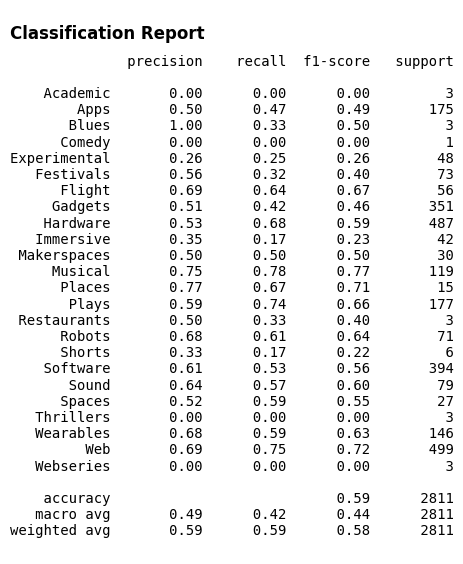

✅ Classification report saved as 'classification_report.png'


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# ------------------ Evaluation ------------------
model.eval()
X_test_t = torch.tensor(X_test, dtype=torch.float32)
preds = model(X_test_t).argmax(1).numpy()

# Generate the classification report (suppress undefined metric warnings)
report = classification_report(y_test, preds, target_names=label_encoder.classes_, zero_division=0)
print(report)

# ------------------ Save Classification Report as PNG ------------------
plt.figure(figsize=(5, 5))
plt.axis('off')

# Add title at the top (y close to 1 for top placement)
plt.text(0.0, 0.95, "Classification Report", fontsize=12, weight='bold', family='sans-serif', va='top')

# Add report text below title
plt.text(0.0, 0.85, report, fontsize=10, family='monospace', va='top')

plt.tight_layout()
plt.savefig("classification_report.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Classification report saved as 'classification_report.png'")


## Display and save the confusion matrix

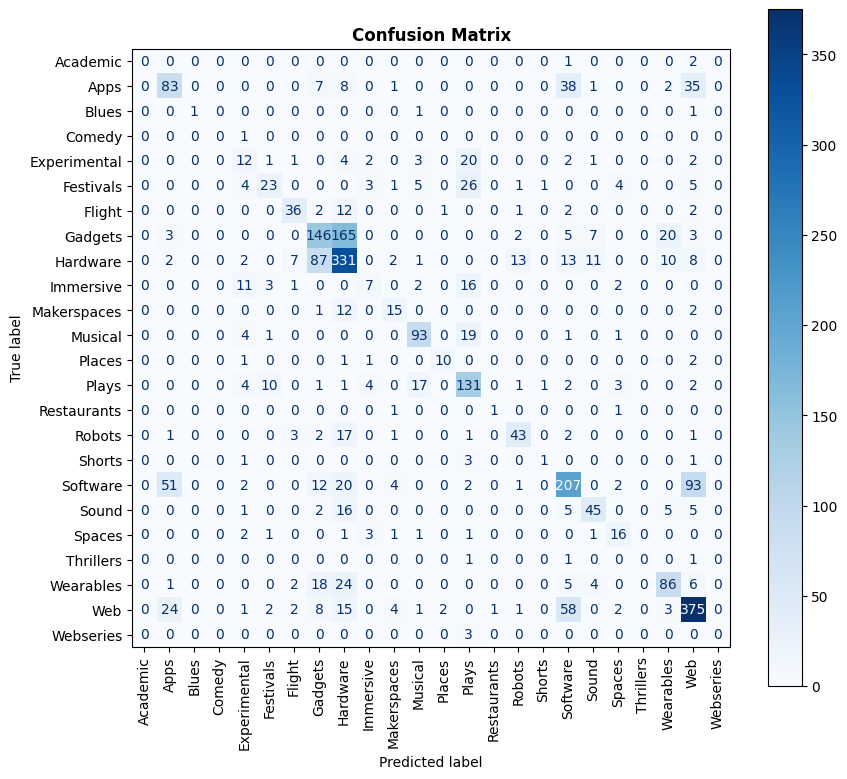

✅ Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Create and customize the plot
fig, ax = plt.subplots(figsize=(9, 8))
disp.plot(cmap='Blues', ax=ax, colorbar=True, xticks_rotation=90)

plt.title("Confusion Matrix", fontsize=12, weight='bold')
plt.tight_layout()

# Save the confusion matrix as PNG
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Confusion matrix saved as 'confusion_matrix.png'")

## Plot and save the loss curves

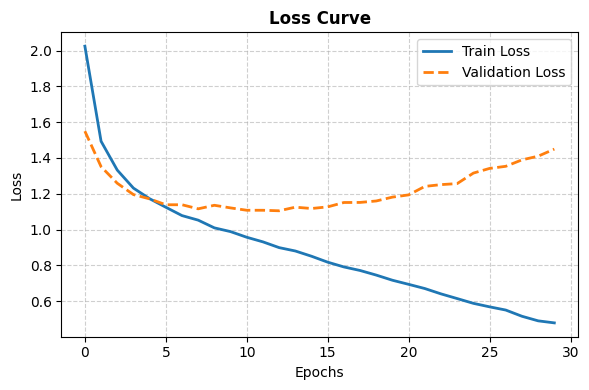

✅ Loss curve saved as 'loss_curve.png'


In [ ]:
import matplotlib.pyplot as plt

# ------------------ Plot Loss Curves ------------------
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2, linestyle='--')

plt.title("Loss Curve", fontsize=12, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the figure as PNG
plt.savefig("loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Loss curve saved as 'loss_curve.png'")


## Plot and save validation accuracy curve

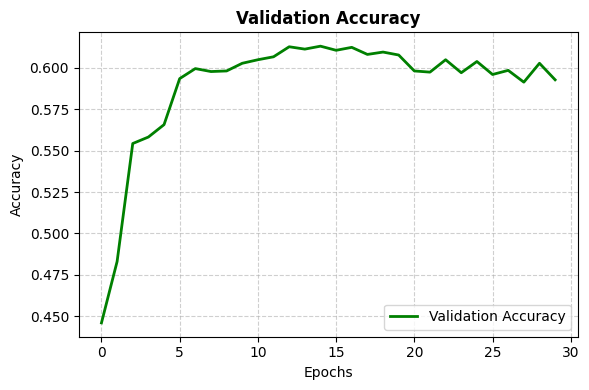

Validation accuracy curve saved as 'validation_accuracy.png'


In [ ]:
import matplotlib.pyplot as plt

# ------------------ Plot Validation Accuracy ------------------
plt.figure(figsize=(6, 4))
plt.plot(val_accs, label="Validation Accuracy", color='green', linewidth=2)

plt.title("Validation Accuracy", fontsize=12, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the figure as PNG
plt.savefig("validation_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Validation accuracy curve saved as 'validation_accuracy.png'")

# Hyper Parameter Tuning 

This section performs a simple random search for hyperparameter tuning for the classifier model. It defines a search space for learning rate, batch size, number of hidden units, and dropout rate, and trains and evaluates the model with different combinations to find the best performing parameters.

In [ ]:
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

def create_model(input_dim, hidden1, hidden2, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden1, hidden2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden2, 24)
    )

def train_eval(model, lr, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    best_val_acc = 0
    for epoch in range(5):  # short training for search
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Validate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb).argmax(1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        best_val_acc = max(best_val_acc, acc)

    return best_val_acc

# Search space
search_space = {
    "lr": [1e-4, 5e-4, 1e-3, 5e-3],
    "batch_size": [32, 64, 128],
    "hidden1": [128, 256, 512],
    "hidden2": [64, 128, 256],
    "dropout": [0.2, 0.3, 0.5]
}

num_trials = 10
best_score = 0
best_params = None

for trial in range(num_trials):
    params = {k: random.choice(v) for k, v in search_space.items()}

    model = create_model(
        input_dim=embeddings.shape[1],
        hidden1=params["hidden1"],
        hidden2=params["hidden2"],
        dropout=params["dropout"]
    )

    score = train_eval(model, params["lr"], params["batch_size"])

    if score > best_score:
        best_score = score
        best_params = params

    print(f"Trial {trial+1}/{num_trials} → Acc={score:.4f} | Params={params}")

print("\n✅ Best Score:", best_score)
print("Best Params:", best_params)

Trial 1/10 → Acc=0.5653 | Params={'lr': 0.005, 'batch_size': 32, 'hidden1': 128, 'hidden2': 256, 'dropout': 0.5}
Trial 2/10 → Acc=0.6016 | Params={'lr': 0.0005, 'batch_size': 32, 'hidden1': 512, 'hidden2': 256, 'dropout': 0.2}
Trial 3/10 → Acc=0.6037 | Params={'lr': 0.001, 'batch_size': 32, 'hidden1': 256, 'hidden2': 256, 'dropout': 0.3}
Trial 4/10 → Acc=0.4280 | Params={'lr': 0.0001, 'batch_size': 64, 'hidden1': 256, 'hidden2': 64, 'dropout': 0.3}
Trial 5/10 → Acc=0.6009 | Params={'lr': 0.001, 'batch_size': 32, 'hidden1': 512, 'hidden2': 64, 'dropout': 0.3}
Trial 6/10 → Acc=0.5859 | Params={'lr': 0.001, 'batch_size': 32, 'hidden1': 128, 'hidden2': 128, 'dropout': 0.3}
Trial 7/10 → Acc=0.4337 | Params={'lr': 0.0001, 'batch_size': 32, 'hidden1': 128, 'hidden2': 128, 'dropout': 0.3}
Trial 8/10 → Acc=0.6037 | Params={'lr': 0.001, 'batch_size': 32, 'hidden1': 256, 'hidden2': 256, 'dropout': 0.3}
Trial 9/10 → Acc=0.5012 | Params={'lr': 0.0005, 'batch_size': 128, 'hidden1': 256, 'hidden2': 6

## Part 3:
Category Prediction using GROUPED categories
Uses Qwen3 pretrained embeddings (kickstarter_data_full_embeddings.pkl)
Grouping Kickstarter categories into broader classes to improve performance.

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ------------------ Load Data ------------------
with open("kickstarter_data_full_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

embeddings = np.array(data["embeddings"])
categories = np.array(data["category"])

## Group categories
This cell defines a mapping to group similar Kickstarter categories into broader classes. This is done to potentially improve classification performance by reducing the number of classes and addressing sparsity.

In [ ]:
# Groups informed by Kickstarter taxonomy + similarity patterns

group_map = {
    "Tech": ["Apps","Gadgets","Hardware","Robots","Software","Wearables","Web"],
    "Film & Media": ["Shorts","Webseries","Thrillers","Comedy","Plays","Musical","Sound"],
    "Art & Experimental": ["Experimental","Immersive","Blues"],
    "Spaces & Places": ["Spaces","Places","Makerspaces"],
    "Festivals": ["Festivals"],
    "Restaurants": ["Restaurants"],
    "Flight": ["Flight"],
    "Education": ["Academic"],
}

# Default group for anything not explicitly listed
def group_category(cat):
    for group, members in group_map.items():
        if cat in members:
            return group
    return "Other"

grouped_labels = np.array([group_category(c) for c in categories])

## Label encode, split data, and create DataLoaders for grouped categories
This section performs label encoding on the newly created grouped categories, splits the data into train, validation, and test sets using stratification based on the grouped labels, and creates PyTorch DataLoaders for the grouped data. It also defines and trains a classifier model specifically for the grouped categories.

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(grouped_labels)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert to tensors
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# ------------------ Model ------------------
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x): return self.net(x)

model = Classifier(embeddings.shape[1], len(np.unique(labels)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ------------------ Training ------------------
num_epochs = 20
train_losses, val_losses, val_accs = [], [], []

for epoch in range(num_epochs):
    model.train(); total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval(); correct, total, vloss = 0,0,0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            loss = criterion(out, yb)
            vloss += loss.item()
            correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)

    val_losses.append(vloss / len(val_loader))
    acc = correct / total; val_accs.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train {train_losses[-1]:.4f}, Val {val_losses[-1]:.4f}, Acc {acc:.4f}")

Epoch 1/20, Train 0.5603, Val 0.3854, Acc 0.8687
Epoch 2/20, Train 0.3678, Val 0.3415, Acc 0.8830
Epoch 3/20, Train 0.3247, Val 0.3131, Acc 0.8922
Epoch 4/20, Train 0.3010, Val 0.3529, Acc 0.8773
Epoch 5/20, Train 0.2764, Val 0.3197, Acc 0.8904
Epoch 6/20, Train 0.2586, Val 0.3101, Acc 0.8997
Epoch 7/20, Train 0.2379, Val 0.3207, Acc 0.8915
Epoch 8/20, Train 0.2225, Val 0.3139, Acc 0.8972
Epoch 9/20, Train 0.2044, Val 0.3251, Acc 0.8972
Epoch 10/20, Train 0.1847, Val 0.3272, Acc 0.8922
Epoch 11/20, Train 0.1740, Val 0.3322, Acc 0.8958
Epoch 12/20, Train 0.1563, Val 0.3775, Acc 0.8904
Epoch 13/20, Train 0.1398, Val 0.3754, Acc 0.8904
Epoch 14/20, Train 0.1254, Val 0.3982, Acc 0.8922
Epoch 15/20, Train 0.1113, Val 0.4219, Acc 0.8911
Epoch 16/20, Train 0.1021, Val 0.4336, Acc 0.8851
Epoch 17/20, Train 0.0880, Val 0.5087, Acc 0.8940
Epoch 18/20, Train 0.0876, Val 0.5051, Acc 0.8872
Epoch 19/20, Train 0.0741, Val 0.5061, Acc 0.8940
Epoch 20/20, Train 0.0760, Val 0.5617, Acc 0.8897


## Evaluate the model with grouped categories and display classification report

                    precision    recall  f1-score   support

Art & Experimental       0.45      0.38      0.41        93
         Education       0.00      0.00      0.00         3
         Festivals       0.35      0.44      0.39        72
      Film & Media       0.73      0.69      0.71       389
            Flight       0.68      0.61      0.64        56
       Restaurants       0.00      0.00      0.00         3
   Spaces & Places       0.82      0.44      0.57        73
              Tech       0.94      0.97      0.95      2122

          accuracy                           0.87      2811
         macro avg       0.50      0.44      0.46      2811
      weighted avg       0.87      0.87      0.87      2811



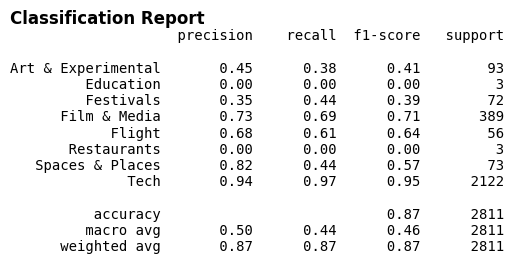

✅ Classification report saved as 'classification_report_3.png'


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# ------------------ Evaluation ------------------
model.eval()
X_test_t = torch.tensor(X_test, dtype=torch.float32)
preds = model(X_test_t).argmax(1).numpy()

# Generate classification report (suppress warnings for undefined metrics)
report = classification_report(y_test, preds, target_names=label_encoder.classes_, zero_division=0)
print(report)

# ------------------ Save Classification Report as PNG ------------------
plt.figure(figsize=(5, 3))
plt.axis('off')

# Add title at the top
plt.text(0.0, 1.0, "Classification Report", fontsize=12, weight='bold', family='sans-serif', va='top')

# Add report text below the title
plt.text(0.0, 0.92, report, fontsize=10, family='monospace', va='top')

plt.tight_layout()
plt.savefig("classification_report.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Classification report saved as 'classification_report_3.png'")


## Display and save the confusion matrix for grouped categories

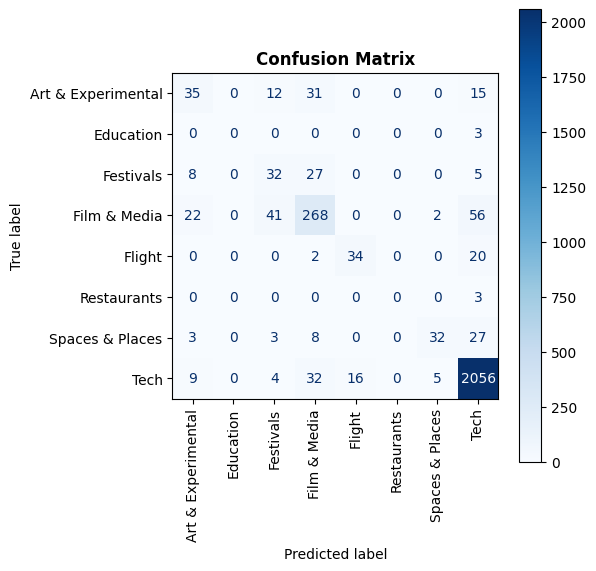

✅ Confusion matrix saved as 'confusion_matrix3.png'


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Create and save the confusion matrix plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True, xticks_rotation=90)

plt.title("Confusion Matrix", fontsize=12, weight='bold')
plt.tight_layout()
plt.savefig("confusion_matrix3.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Confusion matrix saved as 'confusion_matrix3.png'")


## Plot and save the loss curves for grouped categories

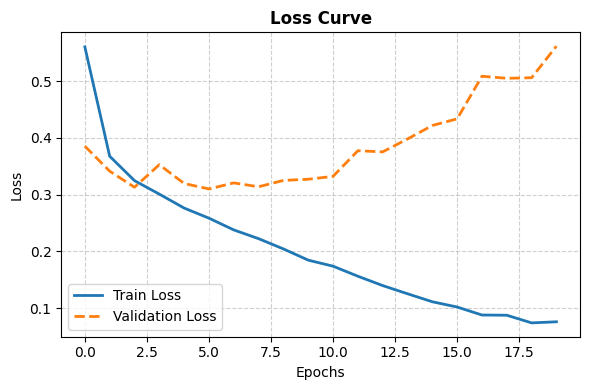

✅ Loss curve saved as 'loss_curve3.png'


In [ ]:
import matplotlib.pyplot as plt

# ------------------ Loss Curves ------------------
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2, linestyle='--')
plt.title("Loss Curve", fontsize=12, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("loss_curve3.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Loss curve saved as 'loss_curve3.png'")

## Plot and save validation accuracy curve for grouped categories

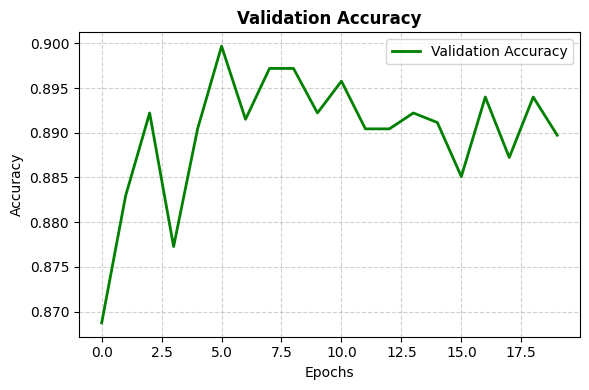

✅ Validation accuracy curve saved as 'validation_accuracy3.png'


In [ ]:
# ------------------ Validation Accuracy Curve ------------------
plt.figure(figsize=(6, 4))
plt.plot(val_accs, label="Validation Accuracy", color='green', linewidth=2)
plt.title("Validation Accuracy", fontsize=12, weight='bold')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("validation_accuracy3.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Validation accuracy curve saved as 'validation_accuracy3.png'")
